In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import lightly 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
from lightly import data
import glob
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler

In [12]:
num_workers = 0#int(os.cpu_count()//2)
seed = 1
max_epochs = 10
#input_size = 128
#num_ftrs = 32

path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1'
path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'

path_to_data_train = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test1'
path_to_data_test = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/E_class'

transform_train = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ElasticTransform(alpha=200.0, sigma=10.0, interpolation=InterpolationMode.BILINEAR, fill=255),
    transforms.RandomAffine(degrees=(-20, 20), scale=(0.8, 1.2), fill = 255),
    transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])
transform_test = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])

transform_simclr = transforms.Compose([
    transforms.Resize((64, 63),antialias=True),  # 画像のサイズ変更
    transforms.Grayscale(num_output_channels=1), #single-channel
    transforms.ElasticTransform(alpha=200.0, sigma=10.0, interpolation=InterpolationMode.BILINEAR, fill=255),
    transforms.RandomAffine(degrees=(-20, 20), scale=(0.8, 1.2), fill = 255),
    #transforms.ToTensor(),           # テンソルに変換
    transforms.Normalize((0.5,), (0.5,)) #single-channel normalization
])


def convert_rgba_to_rgb_with_background(image, background=(255, 255, 255)):
    """RGBA画像を指定した背景色でRGB画像に変換"""
    if image.mode == 'RGBA':
        # 背景を指定して新しい画像を作成
        background_image = Image.new('RGB', image.size, background)
        # アルファチャンネルを使用してマスクを適用
        background_image.paste(image, mask=image.split()[3])  # アルファチャンネルでマスク
        return background_image
    return image  # すでにRGBの場合はそのまま返す

def label_data_dict(path_to_data):
    d = dict() # 画像に対しラベル
    class_indices = dict() # ラベルに対し画像が何個あるか
    for idx, path in enumerate(glob.glob(f'{path_to_data}/*/*/*.png')):
        char = path.split('/')[-2]
        d[path] = char
        
        if char not in class_indices:
            class_indices[char] = [idx]
        else:
            class_indices[char] += [idx]
    return d, class_indices

def cluster_data_dict(path_to_data):
    d = dict() # 画像に対しラベル
    cluster_indices = dict() # クラスタラベルに対し画像が何個あるか
    for idx, path in enumerate(glob.glob(f'{path_to_data}/*/*/*.png')):
        char = path.split('/')[-3]
        d[path] = char
        
        if char not in cluster_indices:
            cluster_indices[char] = [idx]
        else:
            cluster_indices[char] += [idx]
    return d, cluster_indices

class CustomDataset(Dataset):
    def __init__(self, path_to_data, transform=None):
        self.image_paths = []
        self.labels = []
        #self.classes = classes
        
        data, _ = label_data_dict(path_to_data)
        self.image_paths.extend(list(data.keys()))
        self.labels.extend(list(data.values()))

        self.classes = sorted(set(self.labels))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        label_index = self.classes.index(label)
        
        image = Image.open(image_path)
        image = convert_rgba_to_rgb_with_background(image, background=(255, 255, 255))  # 白背景
        #image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)


        return image, label_index

# class_indices: {'label':[data], ...}
class ClassBatchSampler:
    def __init__(self, class_indices):
        self.class_indices = class_indices
        self.classes = list(class_indices.keys())
        #self.current_class = 0

    def __iter__(self):
        # 各クラスのインデックスを順に返す
        for class_label in self.classes:
            indices = self.class_indices[class_label]
            #print(f"Sampling indices for class {class_label}: {indices}", flush=True)  # デバッグ出力
            yield indices

    def __len__(self):
        return len(self.classes)
    
# class_indices: {'label':[data], ...}
class MultiClassBatchSampler:
    def __init__(self, class_indices, cluster_indices):
        self.class_indices = class_indices
        self.classes = list(class_indices.keys())
        
        self.cluster_indices = cluster_indices
        self.clusters = list(cluster_indices.keys())
        #self.current_class = 0

    def __iter__(self):
        # 各クラスのインデックスを順に返す
        for cluster_label in self.clusters:
            indices = self.cluster_indices[cluster_label]
            #print(f"Sampling indices for class {class_label}: {indices}", flush=True)  # デバッグ出力
            yield indices

    def __len__(self):
        return len(self.clusters)

# データセットを作成
dataset_train = CustomDataset(path_to_data_train, transform=transform_train)
dataset_test = CustomDataset(path_to_data_test, transform=transform_test)

_, class_indices_train = label_data_dict(path_to_data_train)
_, class_indices_test = label_data_dict(path_to_data_test)

_, batch_indices_train = cluster_data_dict(path_to_data_train)
_, batch_indices_test = cluster_data_dict(path_to_data_test)

# ランダムに1/5のクラスを選択
#num_selected_classes = len(class_indices_train) // 5
#selected_classes = random.sample(list(class_indices_train.keys()), num_selected_classes)

# 新しい class_indices_train を作成
#class_indices_train_subset = {cls: class_indices_train[cls] for cls in selected_classes}


# サンプラーを使って訓練データローダーを作成
sampler = MultiClassBatchSampler(class_indices_train, batch_indices_train)
dataloader_train = DataLoader(dataset_train, batch_sampler=sampler, num_workers=num_workers)

# サンプラーを使ってテストデータローダーを作成
sampler = MultiClassBatchSampler(class_indices_test, batch_indices_test)
dataloader_test = DataLoader(dataset_test, batch_sampler=sampler)

NUM_CLASSES = len(class_indices_train)#len(class_indices_train)#6379
TEST_NUM_CLASSES = len(class_indices_test)#24

In [5]:
# Initialization of Conv2D parameters according to He et al. (2015)
def he_init(conv2d_layer):
    # kernel size: k1 x k2
    k1, k2 = conv2d_layer.kernel_size

    # input channel
    c = conv2d_layer.in_channels

    # number of summands
    n = k1 * k2 * c
    
    # good standard deviation : sqrt(2/n)
    std = (2 / n) ** 0.5

    # init kernel params ~ Normal(0, std^2)
    nn.init.normal_(conv2d_layer.weight, mean=0.0, std=std)

    # init bias = 0
    nn.init.zeros_(conv2d_layer.bias)
    
class Net(nn.Module):
    def __init__(self,num_classes=NUM_CLASSES):
        super(Net, self).__init__()
        # mtzk: p=0.005 is too small
        #self.embedding_dropout = nn.Dropout(p = 0.005)
        self.embedding_dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)

        #self.conv1 = nn.Conv2d(3,64,3)
        self.conv1 = nn.Conv2d(1,64,3) #single-channel
        # nn.init.normal_(self.conv1.weight, mean=0.0, std=0.1)
        he_init(self.conv1)
        self.bn1 = nn.BatchNorm2d(num_features=64)

        self.conv2 = nn.Conv2d(64,128,3)
        # nn.init.normal_(self.conv2.weight, mean=0.0, std=0.1)
        he_init(self.conv2)
        self.bn2 = nn.BatchNorm2d(num_features=128)

        self.conv3 = nn.Conv2d(128,512,3)
        # nn.init.normal_(self.conv3.weight, mean=0.0, std=0.1)
        he_init(self.conv3)
        self.bn3 = nn.BatchNorm2d(num_features=512)

        self.conv4 = nn.Conv2d(512,512,3)
        # nn.init.normal_(self.conv4.weight, mean=0.0, std=0.1)
        he_init(self.conv4)

        # mtzk: BatchNorm2d は学習パラメータがあるので層ごとに違うのを使うべき
        self.bn4 = nn.BatchNorm2d(num_features=512)

        self.fc1 = nn.Linear(512 * 5 * 5, 4096)
        # mtzk: - std changed according to He et al. (2015)
        #       - init bias = zero
        # nn.init.normal_(self.fc1.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.fc1.bias)

        # mtzk: 2023-12-28: BN also in fc
        self.bn_fc1 = nn.BatchNorm1d(num_features=4096)

        self.fc2 = nn.Linear(4096, 4096)
        # nn.init.normal_(self.fc2.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.fc2.bias)

        # mtzk: 2023-12-28: BN also in fc
        self.bn_fc2 = nn.BatchNorm1d(num_features=4096)

        self.fc3 = nn.Linear(4096, num_classes)
        # nn.init.normal_(self.fc3.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=0.001)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.conv4(x)
        # mtzk: BatchNorm2d は学習パラメータがあるので層ごとに違うのを使うべき
        # x = self.bn3(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.embedding_dropout(x)
        
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        # mtzk: 2023-12-28: BN also in fc
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.fc2(x)
        # mtzk: 2023-12-28: BN also in fc
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.embedding_dropout(x)
        x = self.fc3(x)
        return x

In [6]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self, batch_size=10, transform=None):
        super().__init__()
        
        self.batch_size = batch_size 

        # create a ResNet backbone and remove the classification head
        net = Net()
        self.backbone = Net(num_classes=NUM_CLASSES)
        
        hidden_dim = NUM_CLASSES#net.fc1.in_features
        self.projection_head = SimCLRProjectionHead(
            input_dim=hidden_dim,
            hidden_dim=2048,
            output_dim=128,
            num_layers=2,
            batch_norm=True
        )
        
        self.transform = transform

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        #print(f"Flattened output size: {h.size()}")
        z = self.projection_head(h)
        return z

#    def training_step(self, batch, batch_idx):
        #print(f"Batch content: {batch}")  # バッチの内容を出力して確認
#        (x0, x1), *_ = batch
#        z0 = self.forward(x0)
#        z1 = self.forward(x1)
#        loss = self.criterion(z0, z1)
#        self.log("train_loss_ssl", loss)
#        return loss
    
    def training_step(self, batch, batch_idx):
        images, labels = batch  # 画像とラベルを分けて取得

        # 複数個の異なるビューを作成
        views = [self.transform(images) for _ in range(5)]

        # 各ビューについて順伝播を行い、特徴量を計算
        embeddings = [self.forward(view) for view in views]

        # 損失を計算（例: 各ペアの特徴量間で損失を計算し、その平均をとる）
        total_loss = 0
        num_pairs = 0

        # すべてのペアの組み合わせで損失を計算
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                total_loss += self.criterion(embeddings[i], embeddings[j])
                num_pairs += 1

        # ペア間の平均損失を計算
        loss = total_loss / num_pairs

        # ログに損失を記録
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):# lr=0.075*(self.batch_size)**(1/2)
        #optim = torch.optim.SGD(
        #    self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        #)
        optim = torch.optim.Adam(
            self.parameters(), lr=1e-3, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [7]:
import torch
import torch.nn as nn
from torchvision import models

# 学習済みSimCLRモデルのバックボーンをロード
# (例: ResNet-18)
class FeatureExtractor(nn.Module):
    def __init__(self, simclr_model, num_classes):
        super(FeatureExtractor, self).__init__()
        # SimCLRバックボーンから特徴抽出部分のみを取得
        self.backbone = Net(num_classes=NUM_CLASSES)
    
    def forward(self, x):
        return self.backbone(x)

# SimCLR学習済みモデルをロード（例）
#simclr_model = torch.load("./params/1119-myNet-aug5-10ep.pth")  # 学習済みモデル
simclr_model = torch.load('./params/1206-myNet-aug5-10ep.pth')
feature_extractor = FeatureExtractor(simclr_model, NUM_CLASSES)
feature_extractor.eval()  # 特徴抽出用なので評価モード

/tmp/ipykernel_963770/2594878432.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load('./params/1206-myNet-aug5-10ep.pth')


FeatureExtractor(
  (backbone): Net(
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=12800, out_features=4096, bias=True)
    (bn_fc1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linea

## 分類タスク

In [13]:
from tqdm import tqdm 

# 特徴ベクトルとラベルを準備
features = []
labels = []

with torch.no_grad():
    # tqdmでデータローダーをラップして進捗を表示
    for images, target in tqdm(dataloader_train, desc="Extracting features"):
        embedding = feature_extractor(images)  # 特徴を抽出
        features.append(embedding)
        labels.append(target)

features = torch.cat(features)
labels = torch.cat(labels)

# 保存 (torch.save)
#torch.save({"features": features, "labels": labels}, "features_and_labels.pth")
#print("Features and labels have been saved successfully.")

Extracting features: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


In [11]:
chunk_size = 5000
for i in range(0, len(features), chunk_size):
    features_chunk = features[i:i+chunk_size].contiguous().cpu()
    labels_chunk = labels[i:i+chunk_size].contiguous().cpu()
    
    torch.save(features_chunk, f"/data2/abababam1/HandwrittenTextAlign/simclr/features/features_chunk_{i//chunk_size}.pth")
    torch.save(labels_chunk, f"/data2/abababam1/HandwrittenTextAlign/simclr/labels/labels_chunk_{i//chunk_size}.pth")
    
    print(f"Chunk {i//chunk_size} saved.")

KeyboardInterrupt: 

In [ ]:
# 保存したファイルを読み込む
data = torch.load("features_and_labels.pth")
features = data["features"]
labels = data["labels"]

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

In [14]:
# 線形分類器を構築
classifier = nn.Linear(features.size(1), len(dataset_train.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# 分類器を学習
for epoch in tqdm(range(10), desc="Training Classification; Epoch"):  # 10エポック学習
    classifier.train()
    optimizer.zero_grad()
    output = classifier(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

Training Classification; Epoch: 100%|██████████| 10/10 [00:00<00:00, 140.70it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# デバイス設定 (GPUが利用可能ならGPU、そうでなければCPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 特徴ベクトルとラベルもGPUに転送
#features = features.to(device)
#labels = labels.to(device)

# モデルを構築（次元削減層 + 分類層）
reduced_dim = 1024
classifier = nn.Sequential(
    nn.Linear(features.size(1), reduced_dim),  # 次元削減層
    nn.ReLU(),
    nn.Linear(reduced_dim, len(dataset_train.classes))  # 最終分類層
).to(device)

# 損失関数とオプティマイザ
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

dataloader_train = DataLoader(dataset_train, batch_size=16)

# 分類器を学習
for epoch in tqdm(range(10), desc="Training Classification; Epoch"):  # 10エポック学習
    classifier.train()
    epoch_loss = 0
    
    for batch_features, batch_labels in dataloader_train:
        # バッチごとにデータをGPUに転送
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        output = classifier(batch_features)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss / len(dataloader_train):.4f}")

Using device: cuda


In [15]:
# テストデータで評価
# 特徴抽出
test_features = []
test_labels = []
with torch.no_grad():
    for images, target in dataloader_train:
        embedding = feature_extractor(images)
        test_features.append(embedding)
        test_labels.append(target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

# 分類器で予測
classifier.eval()
with torch.no_grad():
    predictions = classifier(test_features).argmax(dim=1)

# 精度計算
accuracy = (predictions == test_labels).float().mean()
print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

Test Accuracy: 25.90%


## 特徴空間マッピング

In [48]:
import torch
from torch.utils.data import DataLoader

# 特徴ベクトルを保存するリスト
features = []
labels = []

with torch.no_grad():
    for images, targets in dataloader_test:
        # 特徴ベクトルを抽出
        embeddings = feature_extractor(images).flatten(start_dim=1)
        features.append(embeddings)
        labels.append(targets)

# 特徴とラベルを結合
features = torch.cat(features)  # [N, D] (N: サンプル数, D: 特徴次元)
labels = torch.cat(labels)  # [N]

In [49]:
import torch.nn.functional as F

# 特徴ベクトルを正規化
features = F.normalize(features, dim=1)

# コサイン類似度行列の計算
cosine_similarity_matrix = torch.mm(features, features.T)  # [N, N]

# 例: クラスごとの平均類似度を計算
unique_labels = labels.unique()
class_similarities = {}
for label in unique_labels:
    class_indices = (labels == label).nonzero(as_tuple=True)[0]
    class_features = features[class_indices]
    class_similarity = torch.mm(class_features, class_features.T).mean().item()
    class_similarities[label.item()] = class_similarity

print("Class-wise Average Cosine Similarities:")
for label, sim in class_similarities.items():
    print(f"Class {label}: {sim:.4f}")

Class-wise Average Cosine Similarities:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000
Class 10: 1.0000
Class 11: 1.0000
Class 12: 1.0000
Class 13: 1.0000
Class 14: 1.0000
Class 15: 1.0000
Class 16: 1.0000
Class 17: 1.0000
Class 18: 1.0000
Class 19: 1.0000
Class 20: 1.0000
Class 21: 1.0000
Class 22: 1.0000
Class 23: 1.0000
Class 24: 1.0000
Class 25: 1.0000
Class 26: 1.0000
Class 27: 1.0000
Class 28: 1.0000
Class 29: 1.0000
Class 30: 1.0000
Class 31: 1.0000
Class 32: 1.0000
Class 33: 1.0000
Class 34: 1.0000
Class 35: 1.0000
Class 36: 1.0000
Class 37: 1.0000
Class 38: 1.0000
Class 39: 1.0000
Class 40: 1.0000
Class 41: 1.0000
Class 42: 1.0000
Class 43: 1.0000
Class 44: 1.0000
Class 45: 1.0000
Class 46: 1.0000
Class 47: 1.0000
Class 48: 1.0000
Class 49: 1.0000
Class 50: 1.0000
Class 51: 1.0000
Class 52: 1.0000
Class 53: 1.0000
Class 54: 1.0000
Class 55: 1.0000
Class 56: 1.0000
C

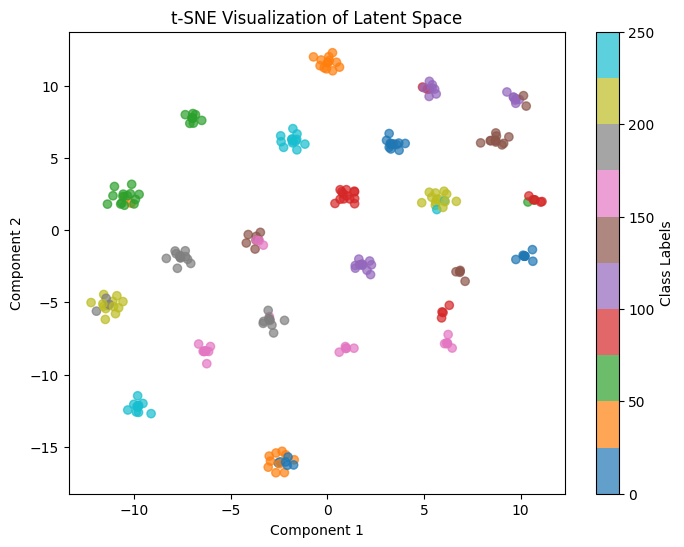

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features.cpu().numpy())

# 可視化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
print(features[:10])  # 最初の10サンプルの特徴ベクトルを確認

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):  # 最初の5枚を可視化
    img, label = dataset_test[i]
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Label: {label}")
    plt.show()

In [ ]:
transform_test_no_processing = transforms.Compose([
    transforms.Resize((64, 63), antialias=True),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# 前処理なしで画像を表示
for i in range(5):
    img, label = dataset_test[i]
    img_no_processing = transform_test_no_processing(Image.open(dataset_test.image_paths[i]).convert('RGB'))
    plt.imshow(img_no_processing.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()


In [ ]:
import torch.nn.functional as F
normalized_features = F.normalize(features, dim=1)
print(normalized_features[:10])  # 正規化後の特徴ベクトルを確認

In [ ]:
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-1.png'
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x9aa8/0x9aa8-0.png'
image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e08/0x4e08-3.png'
#image_path = '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-0.png'
try:
    image = Image.open(image_path)#.convert('RGB')
except Exception as e:
    print(f"Error loading image at {image_path}: {e}")
image

In [ ]:
from PIL import Image

image_paths = [
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-1.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x9aa8/0x9aa8-0.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e08/0x4e08-3.png',
    '/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/test/0x4fee/0x4fee-0.png',
]

for image_path in image_paths:
    try:
        # 画像を開いてRGBに変換
        image = Image.open(image_path).convert('RGB')
        print(f"Image at {image_path} converted to mode: {image.mode}")  # モードを出力
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")

In [ ]:
alpha_channel = image.split()[3]
print(f"Alpha channel unique values: {set(alpha_channel.getdata())}")

In [ ]:
import numpy as np
image_array = np.array(image)
print(f"Image array shape: {image_array.shape}")
print(f"Image array unique values: {np.unique(image_array)}")

In [51]:
import os
import shutil

# ベースディレクトリ
input_dir = "/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train"
output_dir = "/home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1"

for base_dir in glob.glob(f'{input_dir}/*'):
    subdir_name = os.path.basename(base_dir)
    # subdir内のPNGファイルをリストアップ
    png_files = [f for f in os.listdir(base_dir) if f.endswith('.png')]

    # PNGファイルを新しいディレクトリに移動・リネーム
    for file_name in png_files:
        old_file_path = os.path.join(base_dir, file_name)

        # 新しいディレクトリ名とパス
        idx = re.search(r'-(\d+)(?=\..*$)', file_name).group(1)
        new_subdir_name = f"{subdir_name}-{idx}"
        new_subdir_path = os.path.join(output_dir, subdir_name, new_subdir_name)
        os.makedirs(new_subdir_path, exist_ok=True)  # 新しいディレクトリを作成

        # 新しいファイル名とパス
        new_file_name = f"{new_subdir_name}.png"
        new_file_path = os.path.join(new_subdir_path, new_file_name)

        # ファイルを移動・リネーム
        shutil.move(old_file_path, new_file_path)
        print(f"Moved: {old_file_path} -> {new_file_path}")

    print("構造の変更が完了しました。")

Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-0.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-0/0x4e01-0.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-1.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-1/0x4e01-1.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e01/0x4e01-2.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e01/0x4e01-2/0x4e01-2.png
構造の変更が完了しました。
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-0.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e03/0x4e03-0/0x4e03-0.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-1.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x4e03/0x4e03-1/0x4e03-1.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x4e03/0x4e03-2.png

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-15.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-15/0x81df-15.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-16.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-16/0x81df-16.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-17.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-17/0x81df-17.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-18.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-18/0x81df-18.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-19.png -> /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train1/0x81df/0x81df-19/0x81df-19.png
Moved: /home/abababam1/HandwrittenTextAlign/PRMU/simclr/data/train/0x81df/0x81df-20.p

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

